# 파트 8: 중간 지식 베이스

파트 7에서는 속도와 비용에 최적화된 최소 추론 노력을 경험했습니다. 이 파트에서는 현재 사용 가능한 가장 높은 수준의 노력인 **중간 추론 노력**을 소개합니다. 이 노력은 원래 결과가 최적이 아니라고 판단될 때 검색 단계를 추가합니다.

## 단계 1: 환경 변수 로드

아래 셀을 실행하여 Azure 리소스의 구성을 로드하고, 생성된 **.venv(3.11.9)** 환경을 선택하세요.

이번에는 균형 잡힌 추론 기능을 가진 지식 베이스를 생성합니다.

> **⚠️ 문제 해결**
>
> 코드 셀이 멈추고 계속 돌아가면 노트북 상단 툴바에서 **Restart**를 선택하세요. 몇 번 시도해도 문제가 지속되면 VS Code를 완전히 닫고 다시 여세요.

In [1]:
import os

from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv

load_dotenv(override=True) # take environment variables from .env.

# Azure AI Search configuration
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"])

# Knowledge base name
knowledge_base_name = "medium-knowledge-base"

# Azure OpenAI configuration
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_key = os.environ["AZURE_OPENAI_KEY"]
azure_openai_chatgpt_deployment = os.getenv("AZURE_OPENAI_CHATGPT_DEPLOYMENT", "gpt-4.1")
azure_openai_chatgpt_model_name = os.getenv("AZURE_OPENAI_CHATGPT_MODEL_NAME", "gpt-4.1")

print("Environment variables loaded")

Environment variables loaded


## 단계 2: 중간 추론 지식 베이스 생성

아래 코드는 `KnowledgeRetrievalMediumReasoningEffort`를 사용하여 지식 베이스를 생성합니다. 최소 추론과 달리, 이 구성에는 적당한 쿼리 분해와 답변 합성을 위한 Azure OpenAI가 포함됩니다.

중간 추론은 쿼리 계획 및 답변 합성을 활성화하기 위해 Azure OpenAI 모델을 다시 가져오고, 원시 청크 대신 합성된 답변을 반환하기 위해 `ANSWER_SYNTHESIS` 출력 모드를 사용합니다. 구성에는 자연어로 소스 선택을 안내하는 검색 지침도 포함됩니다.

이 균형 잡힌 접근 방식은 합리적인 성능과 비용 효율성을 유지하면서 최소 노력보다 더 나은 추론 기능을 제공합니다.

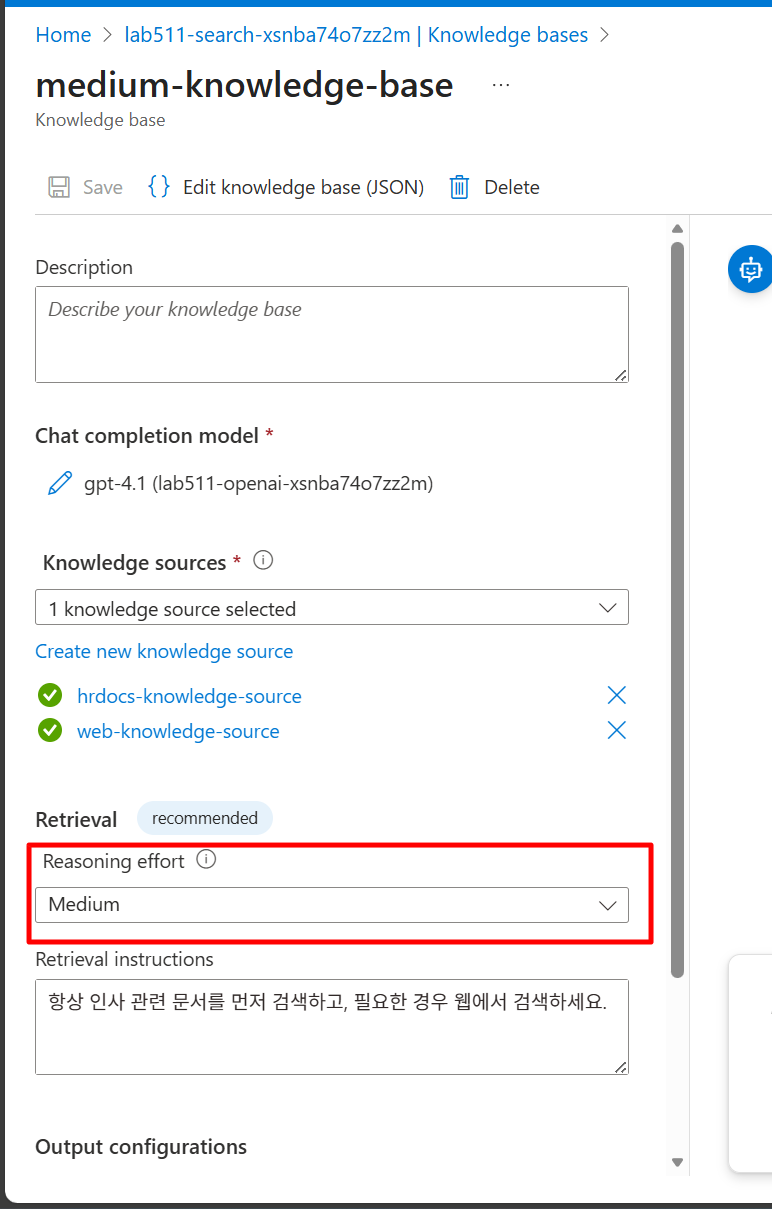

In [3]:
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import AzureOpenAIVectorizerParameters, KnowledgeBase, KnowledgeBaseAzureOpenAIModel, KnowledgeRetrievalMediumReasoningEffort, KnowledgeRetrievalOutputMode, KnowledgeSourceReference, WebKnowledgeSource

index_client = SearchIndexClient(endpoint=endpoint, credential=credential)

aoai_params = AzureOpenAIVectorizerParameters(
    resource_url=azure_openai_endpoint,
    api_key=azure_openai_key,
    deployment_name=azure_openai_chatgpt_deployment,
    model_name=azure_openai_chatgpt_model_name,
)

ks = WebKnowledgeSource(
    name="web-knowledge-source",
    description="Knowledge source for Web"
)
index_client.create_or_update_knowledge_source(knowledge_source=ks)
print(f"Knowledge source '{ks.name}' created or updated successfully.")

knowledge_base = KnowledgeBase(
    name=knowledge_base_name,
    models=[KnowledgeBaseAzureOpenAIModel(azure_open_ai_parameters=aoai_params)],
    knowledge_sources=[
        KnowledgeSourceReference(name="hrdocs-knowledge-source"),
        KnowledgeSourceReference(name="web-knowledge-source"),
    ],
    output_mode=KnowledgeRetrievalOutputMode.ANSWER_SYNTHESIS,
    retrieval_reasoning_effort=KnowledgeRetrievalMediumReasoningEffort(),
    retrieval_instructions="항상 인사 관련 문서를 먼저 검색하고, 필요한 경우 웹에서 검색하세요."
)

index_client.create_or_update_knowledge_base(knowledge_base)
print(f"Knowledge base '{knowledge_base_name}' created or updated successfully.")

Knowledge source 'web-knowledge-source' created or updated successfully.
Knowledge base 'medium-knowledge-base' created or updated successfully.


## 단계 3: 복잡한 다단계 질문 쿼리

아래 쿼리는 여러 단계가 필요한 복잡한 질문으로 중간 추론 기능을 시연합니다: Zava가 휴대용 제품을 출시한 시기 찾기, 그 해의 중국 띠 결정하기, 제품 설명하기.

이 유형의 다단계 추론은 중간 노력이 정교한 쿼리 분해와 성능 최적화의 균형을 어떻게 맞추는지 보여줍니다.

In [7]:
from azure.search.documents.knowledgebases import KnowledgeBaseRetrievalClient
from azure.search.documents.knowledgebases.models import KnowledgeBaseMessage, KnowledgeBaseMessageTextContent, KnowledgeBaseRetrievalRequest, SearchIndexKnowledgeSourceParams, WebKnowledgeSourceParams
from IPython.display import display, Markdown

knowledge_base_client = KnowledgeBaseRetrievalClient(endpoint=endpoint, knowledge_base_name=knowledge_base_name, credential=credential)
web_ks_params = WebKnowledgeSourceParams(
    knowledge_source_name="web-knowledge-source",
    include_references=True,
    include_reference_source_data=True
)
hrdocs_ks_params = SearchIndexKnowledgeSourceParams(
    knowledge_source_name="hrdocs-knowledge-source",
    include_references=True,
    include_reference_source_data=True
)
req = KnowledgeBaseRetrievalRequest(
    messages=[
        KnowledgeBaseMessage(role="user", content=[KnowledgeBaseMessageTextContent(text="""
            Zava는 1985년 선견지명이 있는 기업가들에 의해 설립되었습니다.
            그 해에 그들은 손에 쥘 수 있는 획기적인 제품을 출시하여 업계에 혁명을 일으켰습니다.
            그 해의 중국 십이지신을 쓰고 출시된 제품을 설명하세요.                   
        """)])
    ],
    knowledge_source_params=[
        web_ks_params, hrdocs_ks_params
    ],
    include_activity=True
)

result = knowledge_base_client.retrieve(retrieval_request=req)
display(Markdown(result.response[0].content[0].text))

Zava는 1985년에 혁신에 대한 열정을 가진 선견지명이 있는 기업가들에 의해 설립되었으며, 그 해에 업계에 혁명을 일으킨 획기적인 기술에 중점을 두고 회사를 시작했습니다. 1985년에는 손에 쥘 수 있는 최초의 핸드헬드 개인용 컴퓨터를 출시하여 소비자 전자제품 분야에 큰 변화를 가져왔습니다[ref_id:1].

1985년의 중국 십이지신은 소띠(을축년, 목소)입니다. 이 해에 태어난 사람들은 꾸준함, 실용성, 책임감이 강한 성격을 가진 것으로 여겨집니다[ref_id:0].

## 단계 4: 참조 및 인용 검토

답변을 구성하는 데 사용된 참조를 확인해봅시다. 중간 추론 노력은 검색의 철저함과 효율성의 균형을 맞추면서 상세한 인용을 제공합니다.

In [8]:
import json

references = json.dumps([ref.as_dict() for ref in result.references], indent=2)
print(references)

[
  {
    "type": "web",
    "id": "0",
    "activity_source": 5,
    "source_data": {
      "url": "https://www.thechinajourney.com/ko/1985%EB%85%84-%EC%A1%B0%EB%94%94%EC%95%85-%EC%9A%B4%EB%AA%85%EA%B3%BC-%EC%9E%AC%EC%82%B0/",
      "title": "1985\ub144 \uc2ed\uc774\uc9c0\uc2e0 \ubaa9\uc18c\ub760\uc640 2026\ub144 \uc6b4\uc138 - thechinajourney.com"
    },
    "url": "https://www.thechinajourney.com/ko/1985%EB%85%84-%EC%A1%B0%EB%94%94%EC%95%85-%EC%9A%B4%EB%AA%85%EA%B3%BC-%EC%9E%AC%EC%82%B0/",
    "title": "1985\ub144 \uc2ed\uc774\uc9c0\uc2e0 \ubaa9\uc18c\ub760\uc640 2026\ub144 \uc6b4\uc138 - thechinajourney.com"
  },
  {
    "type": "searchIndex",
    "id": "1",
    "activity_source": 3,
    "source_data": {
      "uid": "810256edf976_aHR0cHM6Ly9tYWdvdHRlaWFkbHNnZW4yLmJsb2IuY29yZS53aW5kb3dzLm5ldC9sYWJkb2NzL1phdmFfQ29tcGFueV9PdmVydmlldy5tZA2_pages_0",
      "blob_path": "/hrdocs/Zava_Company_Overview.md",
      "snippet": "# Zava\r\n\r\n*Disclaimer: This content is generated by AI and m

## 단계 5: 추론 활동 분석

아래 셀을 실행하여 중간 추론 노력이 복잡한 쿼리를 어떻게 처리했는지 보여주는 활동 로그를 확인합니다. 쿼리 분해, 검색 지침에 따른 소스 선택, 최종 답변을 합성하기 위해 수행된 추론 단계의 증거를 볼 수 있습니다.

In [9]:
import pandas as pd

activity_types = [{"type": a.type} for a in result.activity]

df = pd.DataFrame(activity_types)

print("Activity Log Steps")
df

Activity Log Steps


,type
0,modelQueryPlanning
1,searchIndex
2,searchIndex
3,searchIndex
4,web
5,web
6,web
7,modelQueryPlanning
8,searchIndex
9,agenticReasoning


In [10]:
activity_content = json.dumps([a.as_dict() for a in result.activity], indent=2)
print("Activity Details")
print(activity_content)

Activity Details
[
  {
    "id": 0,
    "type": "modelQueryPlanning",
    "elapsed_ms": 2014,
    "input_tokens": 2207,
    "output_tokens": 191
  },
  {
    "id": 1,
    "type": "searchIndex",
    "elapsed_ms": 360,
    "knowledge_source_name": "hrdocs-knowledge-source",
    "query_time": "2026-01-22T14:32:56.357Z",
    "count": 16,
    "search_index_arguments": {
      "search": "Zava 1985\ub144 \uc124\ub9bd \ubc0f 1985\ub144 \ucd9c\uc2dc \uc81c\ud488 \uc815\ubcf4 HR \ubb38\uc11c",
      "source_data_fields": [
        {
          "name": "snippet"
        },
        {
          "name": "uid"
        },
        {
          "name": "blob_path"
        }
      ],
      "search_fields": [
        {
          "name": "snippet"
        }
      ],
      "semantic_configuration_name": "semantic-configuration"
    }
  },
  {
    "id": 2,
    "type": "searchIndex",
    "elapsed_ms": 385,
    "knowledge_source_name": "hrdocs-knowledge-source",
    "query_time": "2026-01-22T14:32:56.743Z",
    

## 요약

이제 정교한 추론 기능과 성능 최적화의 균형을 맞추는 중간 추론 지식 베이스를 경험했습니다.

**기억해야 할 핵심 개념:**
- `KnowledgeRetrievalMediumReasoningEffort`는 추론 정교함과 성능의 균형을 맞춥니다
- Azure OpenAI 모델은 적당한 쿼리 분해와 답변 합성을 가능하게 합니다
- `ANSWER_SYNTHESIS` 출력 모드는 적절한 인용과 함께 합성된 답변을 제공합니다
- `retrieval_instructions`는 소스 선택을 안내합니다 (먼저 hrdocs, 필요시 웹)
- 복잡한 다단계 쿼리는 정교한 정보 요구를 처리하는 중간 추론의 능력을 보여줍니다

### 다음 단계

🎉 **축하합니다!** LAB511 지식 베이스 워크샵의 8개 파트를 모두 완료했습니다. 이제 기본 단일 소스 쿼리부터 최적화된 추론 전략까지 Azure AI Search 지식 베이스의 전체 스펙트럼을 이해했습니다.

- [저장소](https://github.com/microsoft/ignite25-LAB511-build-agentic-knowledge-bases-next-level-rag-with-azure-ai-search)를 클론하고 스타를 눌러 더 탐색해보세요.
- 더 많은 정보는 [Azure AI Search 문서](https://learn.microsoft.com/en-us/azure/search/)를 확인하세요.
- 이 랩에 대한 피드백을 공유해주세요!

이제 Azure AI Search를 사용하여 특정 요구에 맞춘 고급 에이전틱 지식 베이스를 구축할 준비가 되었습니다!